# Hypertension Prediction Model

### Step 1: Import libraries

In [1]:
import os, glob, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.model_selection import train_test_split

C:\Users\rocky\AppData\Local\Temp\ipykernel_36740\852393205.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Step 2: Read dataset

In [2]:
df = pd.read_csv("C:/Users/rocky/OneDrive/Desktop/Ocular-Disease-Recognition/data/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


### Step 3. Extracting Pathological Myopia & Normal information from the dataset

##### Myopia images

In [3]:
def has_hyper(text):
    if "hypertensive" in text:
        return 1
    else:
        return 0

In [4]:
df["left_hyper"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_hyper(x))
df["right_hyper"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_hyper(x))

In [5]:
left_hyper = df.loc[(df.H ==1) & (df.left_hyper == 1)]["Left-Fundus"].values
left_hyper[:15]

array(['11_left.jpg', '23_left.jpg', '28_left.jpg', '32_left.jpg',
       '45_left.jpg', '62_left.jpg', '116_left.jpg', '120_left.jpg',
       '127_left.jpg', '139_left.jpg', '176_left.jpg', '179_left.jpg',
       '272_left.jpg', '296_left.jpg', '300_left.jpg'], dtype=object)

In [6]:
right_hyper = df.loc[(df.H ==1) & (df.right_hyper == 1)]["Right-Fundus"].values
right_hyper[:15]

array(['11_right.jpg', '23_right.jpg', '28_right.jpg', '32_right.jpg',
       '45_right.jpg', '62_right.jpg', '95_right.jpg', '116_right.jpg',
       '120_right.jpg', '127_right.jpg', '139_right.jpg', '176_right.jpg',
       '179_right.jpg', '272_right.jpg', '296_right.jpg'], dtype=object)

In [7]:
print("Number of images in left hypertension: {}".format(len(left_hyper)))
print("Number of images in right hypertension: {}".format(len(right_hyper)))

Number of images in left hypertension: 191
Number of images in right hypertension: 191


##### Normal images

In [8]:
left_normal = df.loc[(df.H ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(191,random_state=42).values
right_normal = df.loc[(df.H ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(191,random_state=42).values

In [9]:
hyper = np.concatenate((left_hyper,right_hyper),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

print(len(hyper),len(normal))

382 382


### Step 4: Creating dataset from images

In [10]:
image_set_dir = "C:/Users/rocky/OneDrive/Desktop/URO/dataset/archive/preprocessed_images"

image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(image_set_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [12]:
dataset = create_dataset(hyper, 1)

100%|██████████| 382/382 [00:13<00:00, 27.57it/s]


In [13]:
len(dataset)

762

In [14]:
dataset = create_dataset(normal, 0)

100%|██████████| 382/382 [00:37<00:00, 10.23it/s]


In [15]:
len(dataset)

1144

##### Image presentation

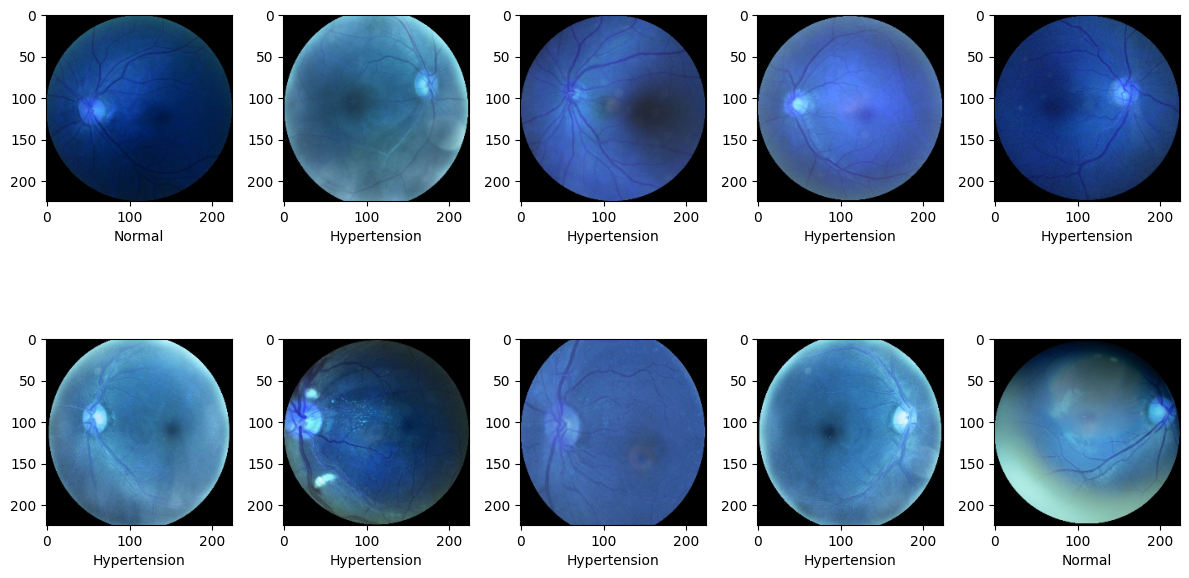

In [16]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Hypertension"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

##### Dividing dataset into x (features) & y (target)

In [17]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

### Step 5: Creating Model

In [18]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [19]:
for layer in vgg.layers:
    layer.trainable = False

In [20]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [22]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

##### Early stopping for statistical optimization

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [24]:
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [26]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
29/29 [==============================] - 220s 8s/step - loss: 1.9516 - accuracy: 0.7530 - val_loss: 1.7644 - val_accuracy: 0.8166
Epoch 2/15
29/29 [==============================] - 233s 8s/step - loss: 0.7406 - accuracy: 0.8678 - val_loss: 0.2928 - val_accuracy: 0.9345
Epoch 3/15
29/29 [==============================] - 232s 8s/step - loss: 0.2160 - accuracy: 0.9486 - val_loss: 0.4546 - val_accuracy: 0.8821
Epoch 4/15
29/29 [==============================] - 219s 8s/step - loss: 0.0352 - accuracy: 0.9803 - val_loss: 0.2336 - val_accuracy: 0.9432
Epoch 5/15
29/29 [==============================] - 212s 7s/step - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.3105 - val_accuracy: 0.9520
Epoch 6/15
29/29 [==============================] - 230s 8s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2682 - val_accuracy: 0.9563
Epoch 7/15
29/29 [==============================] - 251s 9s/step - loss: 6.3412e-04 - accuracy: 1.0000 - val_loss: 0.3058 - val_accuracy: 0.9520
Epoch 8/1

In [27]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

8/8 [==============================] - 41s 5s/step - loss: 0.2994 - accuracy: 0.9520
loss: 0.2994278073310852
Accuracy: 0.9519650936126709


In [28]:
pred_y=model.predict(x_test)
y_pred=(pred_y > 0.5).astype("int32")

8/8 [==============================] - 41s 5s/step


In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.983957219251337

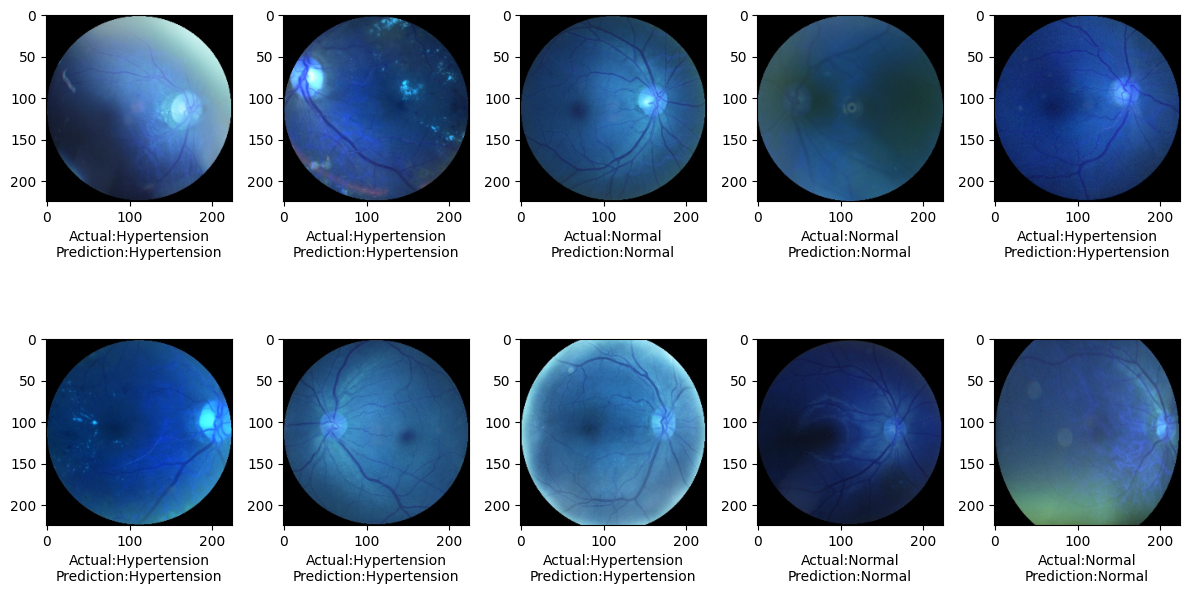

In [29]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Hypertension"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Hypertension"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))

plt.tight_layout() 

In [30]:
model.save('C:/Users/rocky/OneDrive/Desktop/Ocular-Disease-Recognition/models/hyper_model.h5')

c:\Users\rocky\OneDrive\Desktop\Ocular-Disease-Recognition\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
